In [2]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 48.9 MB/s 
     |████████████████████████████████| 6.6 MB 51.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
plt.style.use('ggplot')

In [5]:
MODEL_NAME = 'distilbert-base-cased'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/deeptext 2020.csv', encoding = "UTF-8", encoding_errors='ignore')
train_df = pd.read_csv('/content/drive/MyDrive/deeptext 2020.csv', encoding = "UTF-8", encoding_errors='ignore')
train_df

,Abstract,Label
0,"The data can,\nfor example, come from Electron...",Medicine
1,Clinical text classification with rule-based f...,Biology
2,We generated the rare disease based integrativ...,Health
3,Mining the biomedical literature in the genomi...,Biology
4,Utilization of\nelectronic health records (EHR...,Health
5,One could argue that by simply removing headin...,Medicine
6,"However, as far as we are\naware all available...",Medicine
7,While the OHD is applicable to integration of ...,Health
8,Availability of supporting data\nThe subset of...,Biology
9,Sharing sensitive data across organizational b...,Medicine


In [ ]:
train_df.drop_duplicates(inplace= True)
test_df.drop_duplicates(inplace=True)

In [ ]:
train_df.isna().sum()

Abstract    0
Label       0
dtype: int64

In [ ]:
test_df.isna().sum()

Abstract    0
Label       0
dtype: int64

In [ ]:
print(f"There are {train_df.shape[0]} entries in the training dataframe")
train_df.head()

There are 15 entries in the training dataframe


,Abstract,Label
0,"The data can,\nfor example, come from Electron...",Medicine
1,Clinical text classification with rule-based f...,Biology
2,We generated the rare disease based integrativ...,Health
3,Mining the biomedical literature in the genomi...,Biology
4,Utilization of\nelectronic health records (EHR...,Health


In [ ]:
print(f"There are {test_df.shape[0]} entries in the test dataframe")
test_df.head()

There are 15 entries in the test dataframe


,Abstract,Label
0,"The data can,\nfor example, come from Electron...",Medicine
1,Clinical text classification with rule-based f...,Biology
2,We generated the rare disease based integrativ...,Health
3,Mining the biomedical literature in the genomi...,Biology
4,Utilization of\nelectronic health records (EHR...,Health


In [ ]:
max_words = []
for row in train_df['Abstract']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 235


In [ ]:
test_str = test_df['Abstract'][0]
print(test_str)

def remove_https(row):
    return re.sub(r'http\S+', '', row)

remove_https(test_str)

The data can,
for example, come from Electronic Health Records
(EHR) (clinical data) or from a research database of a
clinical/epidemiological study (research data).Structure clinical data into queryable forms
In the SMITH project, the patient data is structured and
integrated in a Health Data Storage (HDS) according to
HL7 FHIR.– The system must be able to correctly compute
phenotypes based on a phenotype specification
(ontology) and input data (see section 'Classification
and calculation of phenotypes').Finally, the T2DM case selection rules are modelled
using the NCoP class T2DM_Case as well as the five
RCoP classes (one for each case type) including Boolean
restrictions (Fig.The ontology as well as the reasoning method were successfully
evaluated with selected phenotypes including SOFA score, socio-economic status, body surface area and WHO BMI
classification based on available medical data.



"The data can,\nfor example, come from Electronic Health Records\n(EHR) (clinical data) or from a research database of a\nclinical/epidemiological study (research data).Structure clinical data into queryable forms\nIn the SMITH project, the patient data is structured and\nintegrated in a Health Data Storage (HDS) according to\nHL7 FHIR.– The system must be able to correctly compute\nphenotypes based on a phenotype specification\n(ontology) and input data (see section 'Classification\nand calculation of phenotypes').Finally, the T2DM case selection rules are modelled\nusing the NCoP class T2DM_Case as well as the five\nRCoP classes (one for each case type) including Boolean\nrestrictions (Fig.The ontology as well as the reasoning method were successfully\nevaluated with selected phenotypes including SOFA score, socio-economic status, body surface area and WHO BMI\nclassification based on available medical data.\n"

In [ ]:
train_df['Abstract'] = train_df['Abstract'].apply(remove_https)
test_df['Abstract'] = test_df['Abstract'].apply(remove_https)

In [ ]:
le = LabelEncoder()
train_df['Label1'] = le.fit_transform(train_df['Label'])
test_df['Label1'] = le.transform(test_df['Label'])

In [ ]:
label_dict = (test_df[['Label','Label1']].drop_duplicates()
             .sort_values(by='Label1')
              .reset_index(drop=True)['Label']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Biology
1 Health
2 Medicine


In [ ]:
# Get the number training samples
num_train_samples = int(train_df.shape[0] * 0.9)

x_train = train_df['Abstract'][:num_train_samples]
print(x_train)
y_train = train_df['Label1'][:num_train_samples]
x_val = train_df['Abstract'][num_train_samples:]
y_val = train_df['Label1'][num_train_samples:]

### Sanity Check
assert(len(x_train) + len(x_val) == train_df.shape[0])

print(f"{len(x_train)} training examples\n{len(x_val)} validation examples")

0     The data can,\nfor example, come from Electron...
1     Clinical text classification with rule-based f...
2     We generated the rare disease based integrativ...
3     Mining the biomedical literature in the genomi...
4     Utilization of\nelectronic health records (EHR...
5     One could argue that by simply removing headin...
6     However, as far as we are\naware all available...
7     While the OHD is applicable to integration of ...
8     Availability of supporting data\nThe subset of...
9     Sharing sensitive data across organizational b...
10    Adverse Drug Reactions from Health Forums.Resu...
11    It does raise the question as\nto what would b...
12    maps,\ninteractive overlays, and the measureme...
Name: Abstract, dtype: object
13 training examples
2 validation examples


In [ ]:
x_test = test_df['Abstract']
y_test = test_df['Label1']
print(f"{len(x_test)} testing examples")

15 testing examples


In [ ]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# Remove all puncutation
def clean_responses(text):
    ### Remove all puncutation
    string.punctuation = string.punctuation.replace('#','')
    for punctuation in string.punctuation:
        text = str(text).replace(punctuation, '')
    
    ### Lowercase
    text = str(text).lower()
    
    ### Removing stop words
    filtered_words = []
    for word in text.split():
        if word not in stop_words:
            filtered_words.append(word)
            
    ### Stemming words
    stemmed = [porter.stem(word) for word in filtered_words]
                
    return ' '.join(stemmed)

In [ ]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X_train_NB = train_df['Abstract'].apply(clean_responses)
print(X_train_NB)
y_train_NB = train_df['Label1']
X_test_NB = test_df['Abstract'].apply(clean_responses)
y_test_NB = test_df['Label1']

0     data exampl come electron health record ehr cl...
1     clinic text classif rulebas featur knowledgegu...
2     gener rare diseas base integr know ledg graph ...
3     mine biomed literatur genom era overview2020 o...
4     util electron health record ehr vast amount po...
5     one could argu simpli remov head paragraph inf...
6     howev far awar avail knowledgegraph method lim...
7     ohd applic integr data multipl practic differ ...
8     avail support data subset corpu semant manual ...
9     share sensit data across organiz boundari ofte...
10    advers drug reaction health forumsresult condu...
11    rais question would suitabl fundament make sub...
12    map interact overlay measur interdisciplinar b...
13    relev document calcul dup would includ descrip...
14    diseas name normal pairwis learn rankw found m...
Name: Abstract, dtype: object


In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)

Accuracy: 1.0


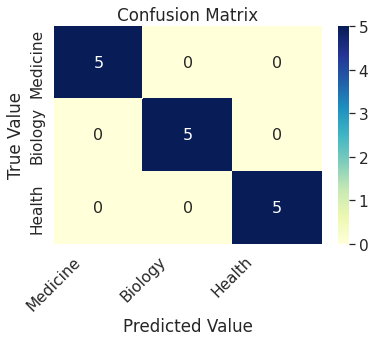

In [ ]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_5 = ['Medicine','Biology','Health'] 

def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_5,columns=[0,1,2]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels_5, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf1(y_test_NB, y_hat)

In [ ]:
print(classification_report(y_test_NB, y_hat, target_names=labels_5))

              precision    recall  f1-score   support

    Medicine       1.00      1.00      1.00         5
     Biology       1.00      1.00      1.00         5
      Health       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [ ]:
max_val = 0
for sent in (x_train.tolist() + x_train.tolist() + x_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 334


In [ ]:
MAX_LENGTH = 234

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [ ]:
x_train
#tokenizer
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

100%|██████████| 2/2 [00:00<00:00, 156.93it/s]


In [ ]:
index_num = 2

print(train_df.loc[index_num]['Label'])

print(x_train[index_num])

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

Health
We generated the rare disease based integrative know-
ledge graph in Neo4j, with a total number of 3,819,623
nodes and 84,223,681 relations from 34 different bio-
medical data resources.Besides “Condition”, we
also derived 32 rare disease categories from GARD as in-
dividual disease classes, such as “Blood Diseases”, “Endo-
crine Diseases” and “Parasitic Diseases” [24], to better
capture rare disease information precisely.Engel P, Bagal S, Broback M, Boice N. Physician and patient perceptions
regarding physician training in rare diseases: the need for stronger
educational initiatives for physicians.In particular, the Genetic and Rare Diseases
(GARD) information center was charged with providing
freely accessible consumer health information in plain
language, and it has been investigating the challenge of
shifting from an entirely manual process to leveraging
computational approaches to curate the accumulated
biomedical and clinical research knowledge of over 6500
rare diseases, 

In [ ]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Downloading:   0%|          | 0.00/338M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 234)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 234)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 234, 768),                                                   
                                 hidden_states=((No                                           

In [ ]:
### Create an output directory
output_dir = './model4_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [ ]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=25, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 30,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/30
1/1 [==============================] - 24s 24s/step - loss: 1.3684 - accuracy: 0.3077 - val_loss: 1.2626 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.9531 - accuracy: 0.4615
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1/1 [==============================] - 10s 10s/step - loss: 0.9531 - accuracy: 0.4615 - val_loss: 1.3548 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.6154
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 8s 8s/step - loss: 0.8703 - accuracy: 0.6154 - val_loss: 1.3507 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 0.8519 - accuracy: 0.6923
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 8s 8s/step

Lowest Validation Loss: epoch 1
Highest Validation Accuracy: epoch 1


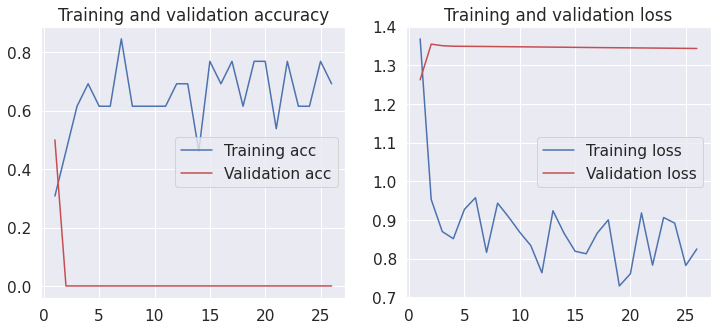

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

In [ ]:
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [ ]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

In [ ]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

Accuracy: 0.6


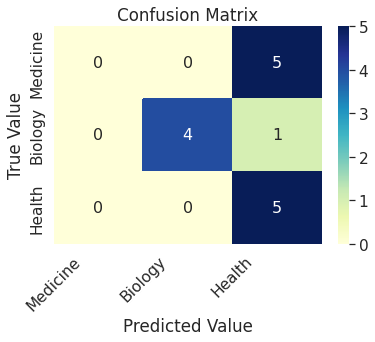

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [ ]:
print(classification_report(y_test, y_hat, target_names=labels_5))

              precision    recall  f1-score   support

    Medicine       0.00      0.00      0.00         5
     Biology       1.00      0.80      0.89         5
      Health       0.45      1.00      0.62         5

    accuracy                           0.60        15
   macro avg       0.48      0.60      0.50        15
weighted avg       0.48      0.60      0.50        15



In [ ]:
le = LabelEncoder()
train_df['Simple_Sentiment_label'] = le.fit_transform(train_df['Label'])
test_df['Simple_Sentiment_label'] = le.transform(test_df['Label'])

label_dict = (test_df[['Label','Simple_Sentiment_label']].drop_duplicates()
              .sort_values(by='Simple_Sentiment_label')
              .reset_index(drop=True)['Label']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Biology
1 Health
2 Medicine


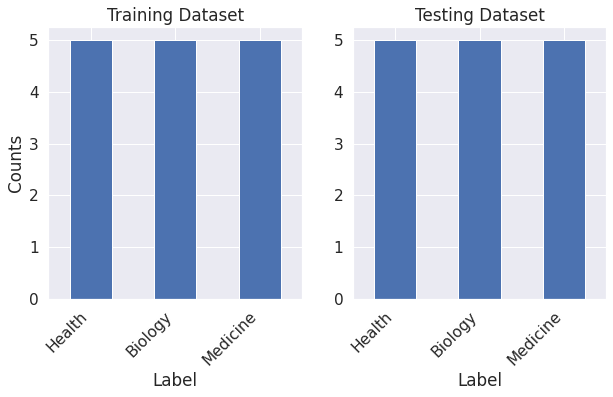

In [ ]:
reorder_labels = [2,1,0]
reorder = ['Medicine', 'Biology', 'Health']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Simple_Sentiment_label').reindex(index=reorder_labels).plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(reorder_labels, reorder, rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Label')

test_df.value_counts('Simple_Sentiment_label').reindex(index=reorder_labels).plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(reorder_labels, reorder, rotation=45, horizontalalignment='right')
plt.title('Testing Dataset')
plt.xlabel('Label');

In [ ]:
### Only need to modify the labels
y_train = train_df['Simple_Sentiment_label'][:num_train_samples]
y_val = train_df['Simple_Sentiment_label'][num_train_samples:]
y_test = test_df['Simple_Sentiment_label']

print(f"{len(y_train)} training examples\n{len(y_val)} validation examples")
print(f"{len(y_test)} testing examples")

13 training examples
2 validation examples
15 testing examples


In [ ]:
y_train_NB = train_df['Simple_Sentiment_label']
y_test_NB = test_df['Simple_Sentiment_label']

In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)

Accuracy: 1.0


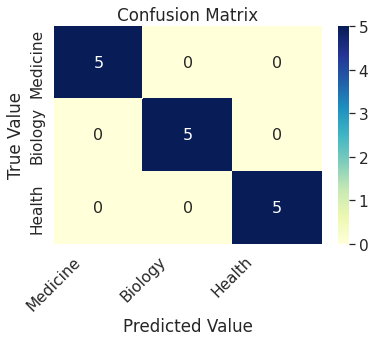

In [ ]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_3 = ['Medicine','Biology','Health'] 

def print_cf2(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_3,columns=[0,1,2]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels_3, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf2(y_test_NB, y_hat)

In [ ]:
print(classification_report(y_test_NB, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Medicine       1.00      1.00      1.00         5
     Biology       1.00      1.00      1.00         5
      Health       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [ ]:
[print(example, '\n') for example in x_test[(y_test == 0) & (np.asarray(y_hat) == 0)][:2]];

Clinical text classification with rule-based features and
knowledge-guided convolutional neural networks.The full text of the
remaining 191 publications was assessed and 114
Table 4 Included publications and their evaluation methodologies (Continued)
Author Year Ref.Barrett N, Weber-Jahnke JH, Thai V. Engineering natural language
processing solutions for structured information from clinical text: extracting
sentinel events from palliative care consult letters.Natural Language Processing (NLP) can be used to
(semi-)automatically process free text.Tchechmedjiev A, Abdaoui A, Emonet V, Zevio S, Jonquet C. SIFR annotator:
ontology-based semantic annotation of French biomedical text and clinical
notes.
 

Mining the biomedical literature in the genomic
era: An overview.2020 Open Access This article is licensed under a Creative Commons Attribution 4.0 International License,
which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appr

In [ ]:
[print(example, '\n') for example in x_test[(y_test == 1) & (np.asarray(y_hat) == 1)][:2]];

We generated the rare disease based integrative know-
ledge graph in Neo4j, with a total number of 3,819,623
nodes and 84,223,681 relations from 34 different bio-
medical data resources.Besides “Condition”, we
also derived 32 rare disease categories from GARD as in-
dividual disease classes, such as “Blood Diseases”, “Endo-
crine Diseases” and “Parasitic Diseases” [24], to better
capture rare disease information precisely.Engel P, Bagal S, Broback M, Boice N. Physician and patient perceptions
regarding physician training in rare diseases: the need for stronger
educational initiatives for physicians.In particular, the Genetic and Rare Diseases
(GARD) information center was charged with providing
freely accessible consumer health information in plain
language, and it has been investigating the challenge of
shifting from an entirely manual process to leveraging
computational approaches to curate the accumulated
biomedical and clinical research knowledge of over 6500
rare diseases, and mor